## Soccer Ball Detection and Localization
### Introduction
This notebook shows the steps taken during the development of a Convolutional Neural Network (CNN) capable of detecting and localizing a soccer ball from pictures taken from a humanoid robot playing in the Robocup competition. The dataset is composed of pictures from 2 different brazilian robocup teams: ITAndroids (http://www.itandroids.com.br/en/) and RoboFei (http://fei.edu.br/robofei/). The notebook will go through the steps taken to explore the data, preprocess it, train a proposed CNN architecture and, finally, fine tune the CNN's hyperparameters.

### Preparing the Data
The first step is to make sure the data is in a standard format. Some of the pictures were in different resolutions, so I used  the OpenCV library to resize and cut them to a 640x480 resolution. Below you can see some examples of the final images.

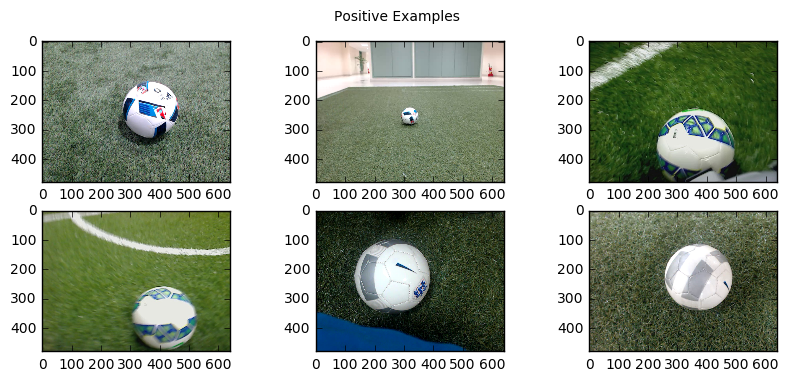

In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_examples(files_location, fig_suptitle):
    files_examples = glob.glob(files_location)
    fig = plt.figure(figsize=(10, 4))
    fig.suptitle(fig_suptitle)
    for i in range(6):
        img = cv2.imread(files_examples[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(2, 3, i + 1)
        ax.imshow(img)

positive_examples = 'final_dataset/examples/positive_examples/*'

show_examples(positive_examples, 'Positive Examples')

The next step was to draw a bounding box arround the ball in every positive image in the dataset and record the location of these boxes. These boxes were recorded in a pickle file. Below you can see the results for the example images shown previously.

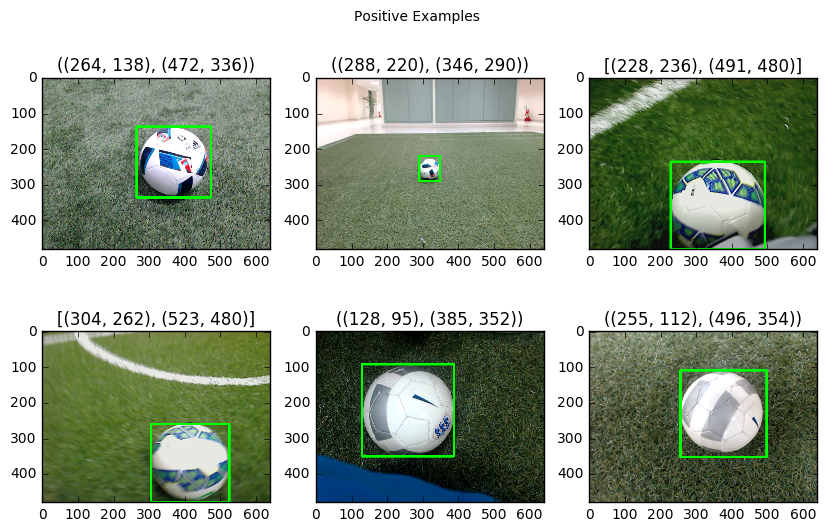

In [2]:
import pickle
from os.path import basename
import numpy as np

with open('final_dataset/positive_pip/_positive.pickle', mode='rb') as f:
    dataset = pickle.load(f)
bboxes = dataset['bboxes']

def draw_bb_examples(files_location, fig_suptitle):
    files_examples = glob.glob(files_location)
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(fig_suptitle)
    for i in range(6):
        name = basename(files_examples[i])
        img = cv2.imread(files_examples[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bbox = bboxes[name]
        cv2.rectangle(img, bbox[0], bbox[1], [0, 255, 0], 5)
        ax = fig.add_subplot(2, 3, i + 1)
        ax.imshow(img)
        ax.set_title(str(bbox))

draw_bb_examples(positive_examples, 'Positive Examples')

### Exploring the Data
First let's explore the distribution of the bounding boxes' positions. I estimated the position of a bounding box by the position of its center and calculated its center as the average of the coordinates recorded for its upper left and bottom right corners. Afterwards, I plotted a 2D histogram to visualize the distribution of the bounding boxes through the 640x480 pixels.

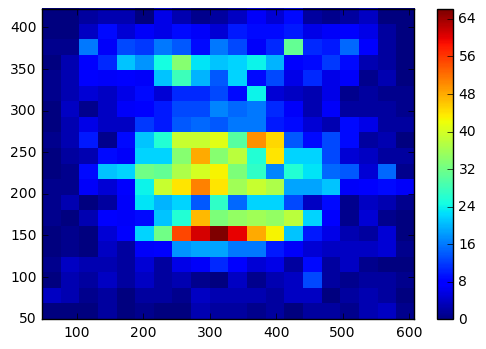

In [3]:
centers = []
for bbox in bboxes.values():
    center = np.array([(bbox[0][0] + bbox[1][0])/2., (bbox[0][1] + bbox[1][1])/2.])
    centers.append(center)
centers = np.array(centers)

plt.hist2d(centers[:,0], centers[:,1], bins=20)
plt.colorbar()

Next, let's look at the distribution of the bounding boxes' sizes. Since some of the images have the ball in its limits, I estimated the size of a bounding box by the length of its longest edge.

(array([  284.,   177.,   301.,   238.,   213.,   249.,   559.,  1323.,
          819.,    33.]),
 array([  22. ,   52.6,   83.2,  113.8,  144.4,  175. ,  205.6,  236.2,
         266.8,  297.4,  328. ]),
 <a list of 10 Patch objects>)

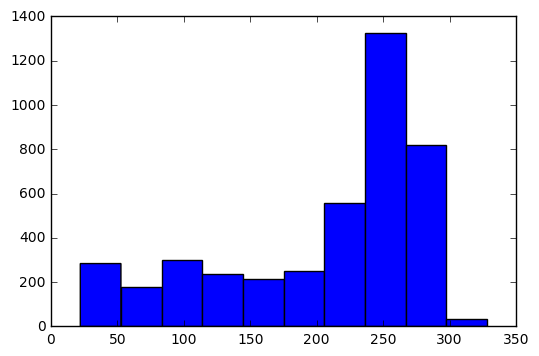

In [4]:
edges = []
for bbox in bboxes.values():
    max_edge = max(abs(bbox[0][0] - bbox[1][0]), abs(bbox[0][1] - bbox[1][1]))
    edges.append(max_edge)
edges = np.array(edges)

plt.hist(edges, bins=10)

As we can see from the previous histograms, the dataset is biased towards bounding boxes with edges arround 250 pixels and positioned in the bottom half of the image. Since the dataset is small, trying to resample or augment it in a way to make it more uniform might result in a repetitive dataset where the CNN can easily overfit.

The idea, then, was to manually split the dataset in train, validation and test sets with approximately the same statistics. This will probably introduce some of the same biases to the CNN, but it will better indicate whenever the CNN is overfitting the training dataset. The statistics for the subsets are shown below.

(array([  71.,   46.,   71.,   60.,   59.,   57.,  141.,  348.,  188.,    9.]),
 array([  22. ,   52.6,   83.2,  113.8,  144.4,  175. ,  205.6,  236.2,
         266.8,  297.4,  328. ]),
 <a list of 10 Patch objects>)

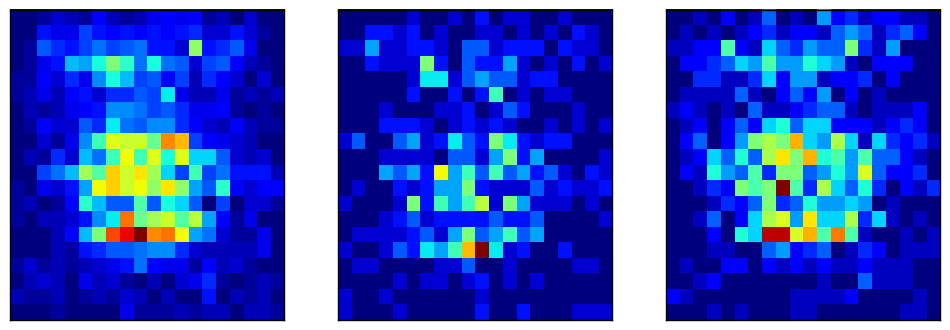

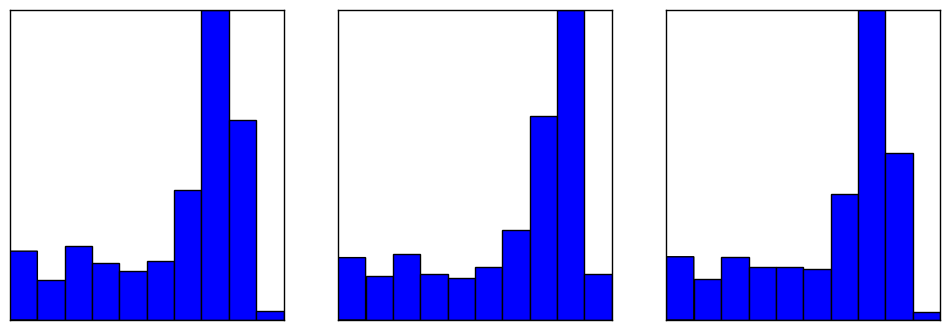

In [5]:
def read_bbox_data(img_files, bboxes):
    center_data = []
    edge_data = []
    for file in img_files:
        name = basename(file)
        bbox = bboxes[name]
        max_edge = max(abs(bbox[0][0] - bbox[1][0]), abs(bbox[0][1] - bbox[1][1]))
        edge_data.append(max_edge)
        center = np.array([(bbox[0][0] + bbox[1][0])/2, (bbox[0][1] + bbox[1][1])/2])
        center_data.append(center)
    return np.array(center_data), np.array(edge_data)

files_train = glob.glob('final_dataset/train/*')
files_val = glob.glob('final_dataset/val/*')
files_test = glob.glob('final_dataset/test/*')

centers_train, edges_train = read_bbox_data(files_train, bboxes)
centers_val, edges_val = read_bbox_data(files_val, bboxes)
centers_test, edges_test = read_bbox_data(files_test, bboxes)

# Histogram of center positions
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.hist2d(centers_train[:,0], centers_train[:,1], bins=20)

ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.hist2d(centers_val[:,0], centers_val[:,1], bins=20)

ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.hist2d(centers_test[:,0], centers_test[:,1], bins=20)


# Histogram of edge lengths
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.hist(edges_train, bins=10)

ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.hist(edges_val, bins=10)

ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.hist(edges_test, bins=10)

### Augmenting the Data
In order to increase the dataset to get more variety in it, I synthetically generated new images from modifications of the ones presented in the dataset. The modifications I used were:

 - translation and rotation

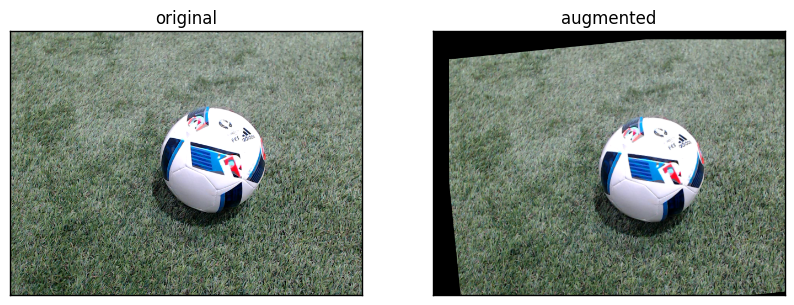

In [6]:
files_examples = glob.glob(positive_examples)

img0 = cv2.imread(files_examples[0])
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

def show_imgs(img_list, title_list=None):
    fig = plt.figure(figsize=(10, 6))
    for i in range(len(img_list)):
        ax = fig.add_subplot(1, len(img_list), i+1, xticks=[], yticks=[])
        ax.imshow(img_list[i])
        ax.set_title(title_list[i])

img1 = img0.copy()

rows, cols = img0.shape[:-1]

name = basename(files_examples[0])
bbox = bboxes[name]
center = np.array([(bbox[0][0] + bbox[1][0])/2, (bbox[0][1] + bbox[1][1])/2])

ang = np.random.uniform(low=-15., high=15.)
M_rot = cv2.getRotationMatrix2D((center[0],center[1]),ang,1.)
img1 = cv2.warpAffine(img1,M_rot,(cols,rows))

tx = np.random.randint(low=-50, high=51)
ty = np.random.randint(low=-40, high=41)
M = np.float32([[1,0,tx],[0,1,ty]])
img1 = cv2.warpAffine(img1,M,(cols,rows))

show_imgs([img0, img1], ['original', 'augmented'])

 - flip (mirror)

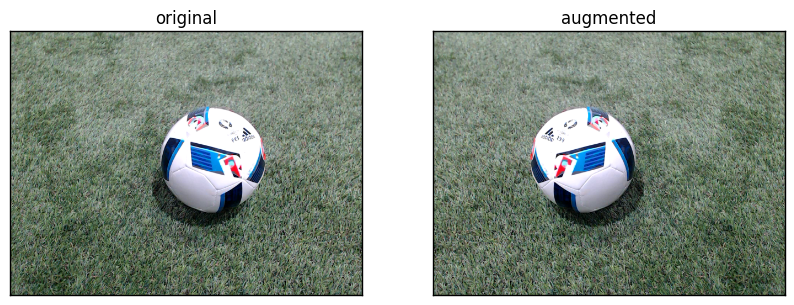

In [7]:
img1 = img0.copy()
img1 = cv2.flip(img1, 1)

show_imgs([img0, img1], ['original', 'augmented'])

 - gamma correction

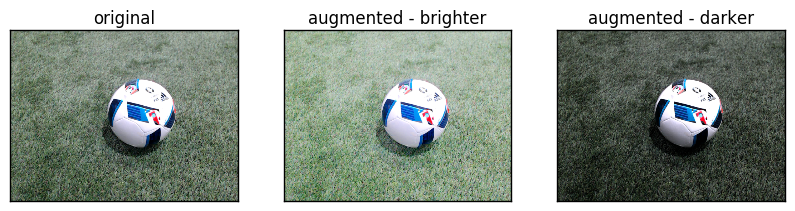

In [8]:
img1 = img0.copy()

img1 = cv2.cvtColor(img1.astype(np.uint8), cv2.COLOR_RGB2HSV)
img1 = img1/255.
gamma = np.random.uniform(low=0.5, high=0.6)
img1_bright = img1.copy()
img1_dark = img1.copy()
img1_bright[:, :, 2] = img1[:, :, 2]**gamma
img1_dark[:, :, 2] = img1[:, :, 2]**(1./gamma)
img1_bright = cv2.cvtColor((img1_bright*255.).astype(np.uint8), cv2.COLOR_HSV2RGB)
img1_dark = cv2.cvtColor((img1_dark*255.).astype(np.uint8), cv2.COLOR_HSV2RGB)

show_imgs([img0, img1_bright, img1_dark], ['original', 'augmented - brighter', 'augmented - darker'])

 - shadow addition

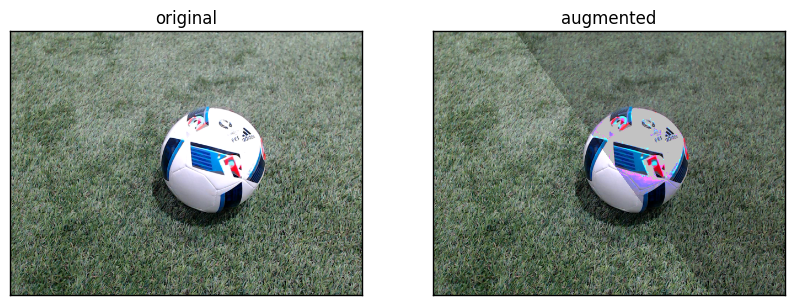

In [9]:
rows_m = np.mgrid[0:rows,0:cols][0]
cols_m = np.mgrid[0:rows,0:cols][1]

shadow_mask = 0*img0[:,:,1]
top_col = cols*np.random.uniform()
top_row = 0
bottom_row = rows
bottom_col = cols*np.random.uniform()
shadow_mask[((rows_m-top_row)*(bottom_col-top_col) >= (bottom_row - top_row)*(cols_m-top_col))] = 1

img1 = img0.copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
side = np.random.randint(0, 2)
img1[:,:,1][shadow_mask==side] = img1[:,:,1][shadow_mask==side]*np.random.uniform(0.6, 1.)
img1 = cv2.cvtColor(img1, cv2.COLOR_HLS2RGB)

show_imgs([img0, img1], ['original', 'augmented'])

### Preprocessing the Data
To avoid vanishing and exploding gradients, overfloating calculations and feature dominance, it's common practice in machine learning to normalize the data before running it through the estimator. The data in this case are RGB images with pixel values ranging from 0 to 255. As a good approximation to normalizing the data, I simply divided the images by 255. I also normalized the coordinates for the bounding boxes to help the CNN to train faster.

The system will run in real time on a humanoid robot with limited hardware specifications. Because of that, the proposed CNN can't be too computationally expensive. With that in mind, another preprocessing step taken was to resize the images to a 64x64 resolution. In this notebook, I left this resize operation commented out in the *preprocess* function and applied it in a later code block in the whole dataset at once to limit the memory requirements for this notebook.

For the final Keras model, both these operations should be incorporated to the model as non-trainable Lambda layers to allow them to be accelerated via GPU processing. For the notebook, the final pipelines for preprocessing and augmenting the data is written in the next code block.

In [10]:
def preprocess(img, target):
    
    img = img.copy()
    #bbox = bbox.copy()
    
    #img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    
    img = img/255.
    
    #bbox[0] = bbox[0]*64./np.array([640., 480.])
    #bbox[1] = bbox[1]*64./np.array([640., 480.])
    
    return img, target.reshape((-1,))

def augment(img, target):
    
    rows, cols, _ = img.shape
    img = img.copy()
    bbox = target.copy()

    rows_m = np.mgrid[0:rows,0:cols][0]
    cols_m = np.mgrid[0:rows,0:cols][1]

    shadow_mask = 0*img[:,:,1]
    top_col = cols*np.random.uniform()
    top_row = 0
    bottom_row = rows
    bottom_col = cols*np.random.uniform()
    shadow_mask[((rows_m-top_row)*(bottom_col-top_col) >= (bottom_row - top_row)*(cols_m-top_col))]=1

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    side = np.random.randint(0, 2)
    img[:,:,1][shadow_mask==side] = img[:,:,1][shadow_mask==side]*np.random.uniform(0.6, 1.)
    img = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    
    # 50% chance of flipping the image
    flip = np.random.uniform(low=-0.5, high=0.5)
    if flip >= 0:
        img = cv2.flip(img, 1)
        bbox[0] = np.array([1 - bbox[0][0], bbox[0][1]])
        bbox[1] = np.array([1 - bbox[1][0], bbox[1][1]])

    # Gamma correction to augment data with respect
    # to brightness
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)
    img = img/255.
    gamma = np.random.uniform(low=0.5, high=2.0)
    img[:,:,2] = img[:,:,2]**gamma
    img = cv2.cvtColor((img*255.).astype(np.uint8), cv2.COLOR_HSV2RGB)

    #center = np.array([(bbox[0][0] + bbox[1][0])/2, (bbox[0][1] + bbox[1][1])/2])
    center = (bbox[0] + bbox[1])/2.
    ang = np.random.uniform(low=-15., high=15.)
    M_rot = cv2.getRotationMatrix2D((center[0]*cols,center[1]*rows),ang,1.)
    img = cv2.warpAffine(img,M_rot,(cols,rows))

    tx = np.random.randint(low=-int(0.1*cols), high=int(0.1*cols + 1))
    ty = np.random.randint(low=-int(0.1*rows), high=int(0.1*rows + 1))
    M = np.float32([[1,0,tx],[0,1,ty]])
    img = cv2.warpAffine(img,M,(cols,rows))
    
    bbox[0] += np.array([tx, ty], dtype=np.float_)/np.array([cols, rows], dtype=np.float_)
    bbox[1] += np.array([tx, ty], dtype=np.float_)/np.array([cols, rows], dtype=np.float_)
    #center += np.array([tx, ty], dtype=np.float_)/np.array([cols, rows], dtype=np.float_)
    
    target = bbox
    
    return img, target

### Getting Ready to Train
As mentioned previously, the data was manually separated in train, validation and test sets. The next code block reads in the images from 3 separate folders and organizes them in 3 different arrays along with their respectives bounding boxes lists.

In [11]:
def read_dataset(img_files, bboxes):
    img_data = []
    bbox_data = []
    for file in img_files:
        img_name = basename(file)
        bbox = np.array(bboxes[img_name], dtype=np.float_)
        bbox[0] = bbox[0]/np.array([640., 480.])
        bbox[1] = bbox[1]/np.array([640., 480.])
        img = cv2.imread('C:/Users/Lucas/Desktop/final_dataset/positive/' + img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
        img_data.append(img)
        bbox_data.append(bbox)
    return np.array(img_data), np.array(bbox_data)

imgs_train, bboxes_train = read_dataset(files_train, bboxes)
imgs_val, bboxes_val = read_dataset(files_val, bboxes)
imgs_test, bboxes_test = read_dataset(files_test, bboxes)

print(imgs_train.shape, bboxes_train.shape)
print(imgs_val.shape, bboxes_val.shape)
print(imgs_test.shape, bboxes_test.shape)

(2621, 64, 64, 3) (2621, 2, 2)
(525, 64, 64, 3) (525, 2, 2)
(1050, 64, 64, 3) (1050, 2, 2)


In order to save some space while training, I used the following generator along with the function *fit_generator*, built-in the keras API. This function fits the model on data yielded by a generator one batch at a time (https://keras.io/models/model/#fit_generator).

In [12]:
from sklearn.utils import shuffle

def batch_generator(img_dataset, target_dataset, batch_size=100, is_val=False):
    
    img_batch = np.empty((batch_size, 64, 64, 3))
    target_batch = np.empty((batch_size, 4))
    
    while True:

        img_dataset, target_dataset = shuffle(img_dataset, target_dataset)
        dataset_size = img_dataset.shape[0]
        for j in range(dataset_size//batch_size):
            for i in range(batch_size):
                img = img_dataset[j*batch_size + i]
                target = target_dataset[j*batch_size + i]
                if is_val:
                    img_batch[i], target_batch[i] = preprocess(img, target)
                else:
                    img, target = augment(img, target)
                    img_batch[i], target_batch[i] = preprocess(img, target)
            
            yield (img_batch, target_batch)

### CNN

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D, GlobalAveragePooling2D

# define cnn model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, 3, input_shape=(64, 64, 3), padding='same', activation='relu'))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(64, 3, padding='same', activation='relu'))
cnn_model.add(MaxPool2D())
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(128, 3, padding='same', activation='relu'))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(128, 3, padding='same', activation='relu'))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(128, 3, padding='same', activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(GlobalAveragePooling2D())
cnn_model.add(Dense(4))

# summarize the model
model = cnn_model
model.summary()

# compile the model
model.compile(loss='mse', optimizer='adam')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [14]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='teste.hdf5',
                               verbose=1, save_best_only=True)

train_data_gen = batch_generator(imgs_train, bboxes_train)
val_data_gen = batch_generator(imgs_val, bboxes_val, is_val=True)
hist = model.fit_generator(train_data_gen, 10, 10, validation_data=val_data_gen, 
                           validation_steps=3, callbacks=[checkpointer])

Epoch 1/10
10/10 [==============================] - 20s - loss: 0.1162 - val_loss: 0.0694
Epoch 2/10
10/10 [==============================] - 19s - loss: 0.0647 - val_loss: 0.0470
Epoch 3/10
10/10 [==============================] - 20s - loss: 0.0542 - val_loss: 0.0516
Epoch 4/10
10/10 [==============================] - 20s - loss: 0.0508 - val_loss: 0.0598
Epoch 5/10
10/10 [==============================] - 18s - loss: 0.0491 - val_loss: 0.0436
Epoch 6/10
10/10 [==============================] - 19s - loss: 0.0460 - val_loss: 0.0446
Epoch 7/10
10/10 [==============================] - 20s - loss: 0.0451 - val_loss: 0.0444
Epoch 8/10
10/10 [==============================] - 20s - loss: 0.0428 - val_loss: 0.0471
Epoch 9/10
10/10 [==============================] - 20s - loss: 0.0403 - val_loss: 0.0400
Epoch 10/10
10/10 [==============================] - 21s - loss: 0.0367 - val_loss: 0.0427


### Results

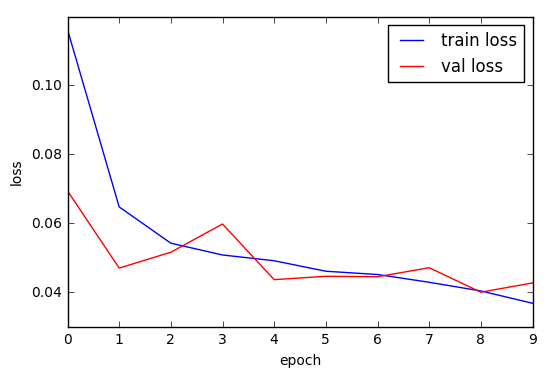

In [15]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], 'r-', label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

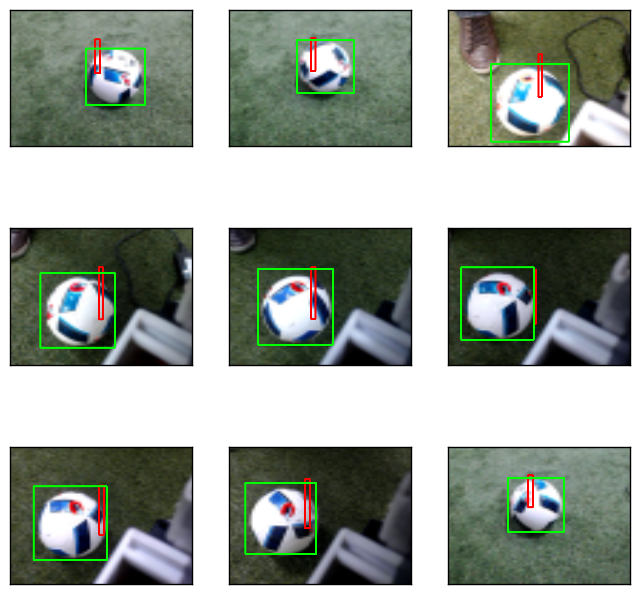

In [16]:
def plot_sample(img, bbox_pred, bbox, axis):
    pt1_pred = (int(bbox_pred[0]*640), int(bbox_pred[1]*480))
    pt2_pred = (int(bbox_pred[2]*640), int(bbox_pred[3]*480))
    pt1 = (int(bbox[0]*640), int(bbox[1]*480))
    pt2 = (int(bbox[2]*640), int(bbox[3]*480))
    img = cv2.resize(img, (640, 480))
    cv2.rectangle(img, pt1_pred, pt2_pred, [255, 0, 0], 5)
    cv2.rectangle(img, pt1, pt2, [0, 255, 0], 5)
    axis.imshow(img)

fig = plt.figure(figsize=(8, 8))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(9):
    img = imgs_test[i:i+1].copy()
    bboxes_pred = model.predict(img/255.0)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_sample(img[0], bboxes_pred[0], np.reshape(bboxes_test[i], (-1,)), ax)
    #ax.set_title(str(centers_pred[i]))
    #ax.set_xlabel(str(centers_val[i]/[640., 480.]))